# Financy EDA and First tests

### Data Sources:
1. Data Source 1: SEC EDGAR DataBase

A) API

B) HTML Reports

**To see the reports in a html way** EDGAR DATABASE || Full Text Search | https://www.sec.gov/edgar/search/#

**Methodology**:

We have a separate file that pulls individual company data from the API. It's not possible with a single request to pull data for more than 1 company.


We decided to segment the company data available in the EDGAR Database by SIC - The Standard Industrial Classification Codes  - that indicates the company's type of business. We thought that in this way we could 1) run the model on a single cluster unit and 2) avoid the extension of unique account types. With more industries, these could result in a infinite list.

We decided to start with the biggest SIC Cluster: Pharmaceuticals Preparations.

As such, we go from a list of 10k companies to a list of 806.

This way we can make a more realistic comparison between companies, as there will be more columns in common, reducing the complexity of the model.

We made that segmentation in a different notebook and we saved it as csv file that we will loaded here.

2. Data Source 2: Yahoo Finance - yfinance Unofficial Python Library

**Methodology**:
We consider that stock-related information can add a lot to our model, so we added the following info:
- stock close price and volume
- number of outstanding shares
- earnings per share

We also have access to: 
- show holders, and inside tradings
- news related to the stock: df with the links, the time when it was posted and what stocks could be afffected

## Product Ideation
**IDEA 1:** Anomaly Detection model

**IDEA 2:** Regression model on stock close price

**IDEA 3:** LLM on html reports

**IDEA 4:** LLM for summarization on news: 


#### TO THINK ABOUT

Problems:
- a lot of unique columns
- a lot of NaNs as a result
- no labeled data

Suggestions:
- Look for PyOD
- AutoEncoder
- Do we need to do entity resolution on the columns or drop columns before we run any model?

## EDA and Feature Engineering

#### Import section

In [59]:
import sys
sys.path.append('/Users/zemariatrindade/BTS/Financy_App/Scripts_and_Data/venv/lib/python3.11/site-packages')

import warnings 
warnings.filterwarnings('ignore') 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import yfinance as yf
from datetime import datetime

#### Data loading

In [3]:
df = pd.read_csv("Model_Data_Pharmaceuticals.csv",index_col=0).drop("start", axis=1)

In [4]:
df.shape

(4003365, 10)

In [5]:
df_sorted = df.iloc[:,[8,0,3,4,5,6,7,2,9,1]]
df_sorted.head()

,ticker,end,fy,fp,form,filed,frame,accn,type,val
0,LLY,2006-12-31,2011.0,FY,10-K,2012-02-24,CY2006Q4I,0001193125-12-078393,AcceleratedShareRepurchasesSettlementPaymentOr...,2.580000e+09
1,LLY,2006-12-31,2011.0,Q3,10-Q,2011-10-28,NaN,0001193125-11-286084,AcceleratedShareRepurchasesSettlementPaymentOr...,2.580000e+09
2,LLY,2006-12-31,2011.0,Q2,10-Q,2011-07-29,NaN,0001193125-11-202740,AcceleratedShareRepurchasesSettlementPaymentOr...,2.580000e+09
3,LLY,2006-12-31,2011.0,Q1,10-Q,2011-04-29,NaN,0001193125-11-117877,AcceleratedShareRepurchasesSettlementPaymentOr...,2.580000e+09
4,LLY,2010-12-31,2010.0,FY,10-K,2011-02-22,CY2010Q4I,0001193125-11-041620,AcceleratedShareRepurchasesSettlementPaymentOr...,2.580000e+09


In [6]:
df_sorted.form.unique()

array(['10-K', '10-Q', '10-Q/A', '8-K', '6-K', '20-F', '10-K/A', '20-F/A',
       '10-KT', '8-K/A', '10-QT', '6-K/A'], dtype=object)

**Discovery 0:**
- There are multiple types of **forms**

#### Types of Forms
- **A** Ammendment to the analogous period

- **6-K** cover page for foreign issuers making filings with the SEC

- **8-K** report of unscheduled material events or corporate changes at a company that could be of importance to the shareholders or the Securities and Exchange Commission

- **20-F** annual report for foreign issuers

- **10-KT** is a filing with the Securities and Exchange Commission (SEC) submitted in lieu of or in addition to a standard 10-K annual report when a company changes the end of its fiscal year

- **10-QT** used when there is a presentation of financial statements during "transitional periods" rather than the standard three-month (quarterly) periods covered by a traditional SEC Form 10-Q.

Foreign companies that want exposure to American markets sometimes go through the process of getting listed as a public company in the U.S. Other times, they become what is known as a foreign private issuer, or FPI for short. Foreign private issuers have the benefit of access to U.S. markets and certain friendly accommodations without having to go through the entire process of getting listed. Below, get an SEC foreign private issuers overview that includes the financial reporting requirements to know.


**!!! Decision:** Let's keep all the form types.

In [7]:
df_sorted = df_sorted.sort_values(["end"])
df_sorted.head()

,ticker,end,fy,fp,form,filed,frame,accn,type,val
2814383,TENX,1967-05-25,2014.0,Q2,10-Q,2013-12-17,CY1967Q2I,0001354488-13-006923,CashAndCashEquivalentsAtCarryingValue,0.0
2814382,TENX,1967-05-25,2014.0,Q1,10-Q,2013-09-17,NaN,0001354488-13-005278,CashAndCashEquivalentsAtCarryingValue,783528.0
2814381,TENX,1967-05-25,2012.0,FY,10-K,2012-07-25,NaN,0001354488-12-003634,CashAndCashEquivalentsAtCarryingValue,0.0
2814380,TENX,1967-05-25,2012.0,Q1,10-Q,2011-09-19,NaN,0001354488-11-003481,CashAndCashEquivalentsAtCarryingValue,0.0
2814384,TENX,1967-08-25,2014.0,Q3,10-Q,2014-03-17,CY1967Q3I,0001354488-14-001188,CashAndCashEquivalentsAtCarryingValue,0.0


**Discovery 1:**
- **filed** date is always after the **end** (of the period) date

In [8]:
df_sorted[(df_sorted["ticker"]=="TEVA") & (df_sorted["filed"]=="2009-05-07")& (df_sorted["type"]=="NetIncomeLoss")] 

,ticker,end,fy,fp,form,filed,frame,accn,type,val
234491,TEVA,2008-03-31,2009.0,Q1,6-K,2009-05-07,CY2008Q1,0001193125-09-102866,NetIncomeLoss,139000000.0
234498,TEVA,2009-03-31,2009.0,Q1,6-K,2009-05-07,NaN,0001193125-09-102866,NetIncomeLoss,451000000.0


**Discovery 2:**
- We can drop **frame** - it's alphanumerical representation of the **end** date - the col **end** already conveys this information
- **fy** is the fiscal year of the report submitted
- in one report there is always 2 end dates - because it's how financial statements are reported: as a difference


In [9]:
df_sorted[(df_sorted["ticker"]=="TENX") & (df_sorted["filed"]=="2012-07-25")& (df_sorted["type"]=="AccountsReceivableNetCurrent")] 

,ticker,end,fy,fp,form,filed,frame,accn,type,val
2813135,TENX,2011-04-30,2012.0,FY,10-K,2012-07-25,CY2011Q1I,0001354488-12-003634,AccountsReceivableNetCurrent,138867.0
2813146,TENX,2012-04-30,2012.0,FY,10-K,2012-07-25,NaN,0001354488-12-003634,AccountsReceivableNetCurrent,13385.0


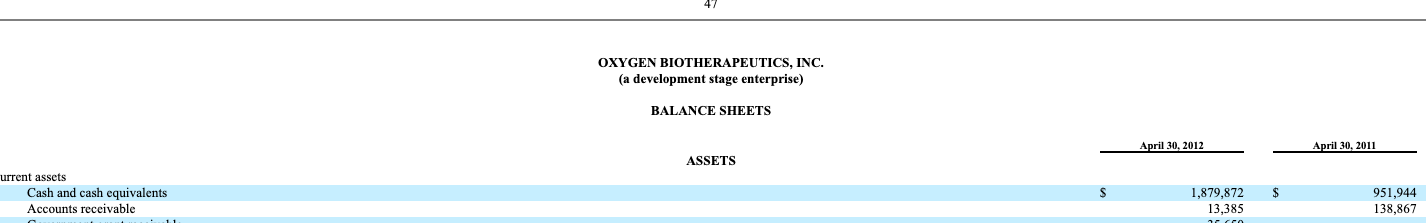

In [10]:
df_sorted[(df_sorted["ticker"]=="CTLT") & (df_sorted["filed"]=="2024-05-08")& (df_sorted["frame"]=="CY2024Q1I")].head()

,ticker,end,fy,fp,form,filed,frame,accn,type,val
306223,CTLT,2024-03-31,2024.0,Q3,10-Q,2024-05-08,CY2024Q1I,0001596783-24-000033,OtherAssetsNoncurrent,341000000.0
306109,CTLT,2024-03-31,2024.0,Q3,10-Q,2024-05-08,CY2024Q1I,0001596783-24-000033,OtherAssetsCurrent,46000000.0
306027,CTLT,2024-03-31,2024.0,Q3,10-Q,2024-05-08,CY2024Q1I,0001596783-24-000033,OtherAccruedLiabilitiesCurrent,583000000.0
303766,CTLT,2024-03-31,2024.0,Q3,10-Q,2024-05-08,CY2024Q1I,0001596783-24-000033,InterestRateCashFlowHedgeAssetAtFairValue,67000000.0
303738,CTLT,2024-03-31,2024.0,Q3,10-Q,2024-05-08,CY2024Q1I,0001596783-24-000033,InterestPayableCurrent,28000000.0


**Discovery 3:**
- the **fp** is the fiscal period. when it is a quarter report, the fiscal quarter is the one associated with the most recent end date. If it's a annual report, the fp will be FY.
  
**Companies have different fiscal calendars**

E.g. For a company that ends its fiscal year on June 30th, the quarters would typically be as follows:

- Q1 (First Quarter): July 1st - September 30th
- Q2 (Second Quarter): October 1st - December 31st
- Q3 (Third Quarter): January 1st - March 31st
- Q4 (Fourth Quarter): April 1st - June 30th

#### !! Conclusion:
- Drop columns: **accn**, **fp**, **frame**
- Evaluate dropping: **fy**, **form**
- Change the columns to the appropriate column types

In [11]:
clean_df = df_sorted.drop(["accn","fp","frame"], axis=1)
clean_df["val"] = clean_df["val"].astype("int") # to optimize memory usage
clean_df["end"] = pd.to_datetime(clean_df["end"])

In [12]:
# there are vals with 0s instead of NaN. Understand why!
clean_df

,ticker,end,fy,form,filed,type,val
2814383,TENX,1967-05-25,2014.0,10-Q,2013-12-17,CashAndCashEquivalentsAtCarryingValue,0
2814382,TENX,1967-05-25,2014.0,10-Q,2013-09-17,CashAndCashEquivalentsAtCarryingValue,783528
2814381,TENX,1967-05-25,2012.0,10-K,2012-07-25,CashAndCashEquivalentsAtCarryingValue,0
2814380,TENX,1967-05-25,2012.0,10-Q,2011-09-19,CashAndCashEquivalentsAtCarryingValue,0
2814384,TENX,1967-08-25,2014.0,10-Q,2014-03-17,CashAndCashEquivalentsAtCarryingValue,0
...,...,...,...,...,...,...,...
2727940,IMNN,2032-12-31,2012.0,10-K,2013-03-18,DeferredTaxAssetsOperatingLossCarryforwardsSub...,20587000
2727939,IMNN,2032-12-31,2013.0,10-K,2014-03-13,DeferredTaxAssetsOperatingLossCarryforwardsSub...,20558000
2732253,IMNN,2032-12-31,2012.0,10-K,2013-03-18,OperatingLossCarryforwards,128882000
2732254,IMNN,2033-12-31,2013.0,10-K,2014-03-13,OperatingLossCarryforwards,139250000


In [13]:
clean_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4003365 entries, 2814383 to 2727941
Data columns (total 7 columns):
 #   Column  Dtype         
---  ------  -----         
 0   ticker  object        
 1   end     datetime64[ns]
 2   fy      float64       
 3   form    object        
 4   filed   object        
 5   type    object        
 6   val     int64         
dtypes: datetime64[ns](1), float64(1), int64(1), object(4)
memory usage: 244.3+ MB


In [14]:
clean_df.type.nunique()

4801

In [15]:
clean_df.ticker.unique()[:5]

array(['TENX', 'SRPT', 'MNKD', 'KAYS', 'NWBO'], dtype=object)

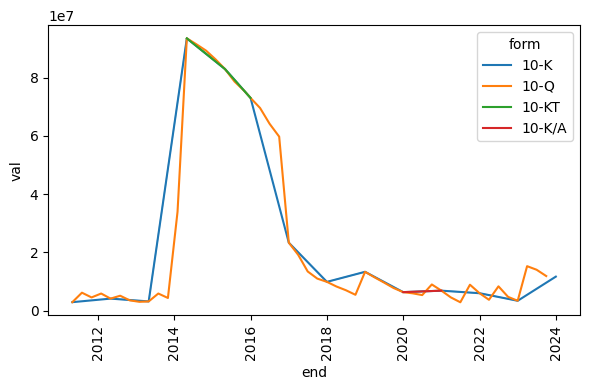

In [16]:
plt.figure(figsize=(6,4))
sns.lineplot(data=clean_df[(clean_df["ticker"] == "TENX") & (clean_df["type"] == "Assets")], y="val", x="end", hue="form")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

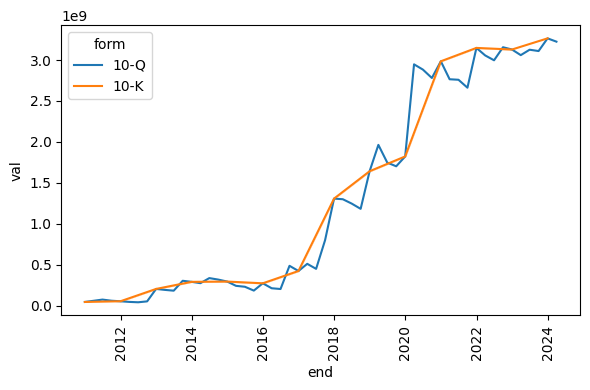

In [17]:
plt.figure(figsize=(6,4))
sns.lineplot(data=clean_df[(clean_df["ticker"] == "SRPT") & (clean_df["type"] == "Assets")], y="val", x="end", hue="form")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

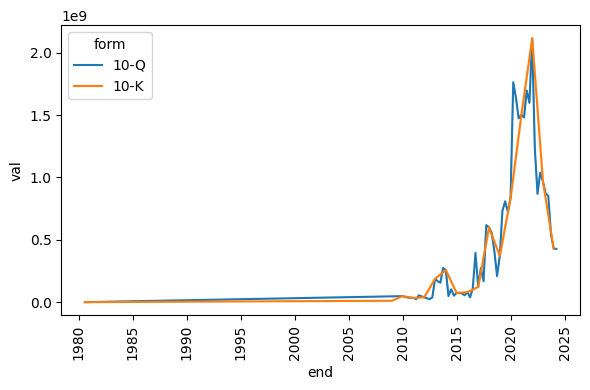

In [18]:
plt.figure(figsize=(6,4))
sns.lineplot(data=clean_df[(clean_df["ticker"] == "SRPT") & (clean_df["type"] == "CashAndCashEquivalentsAtCarryingValue")], y="val", x="end", hue="form")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

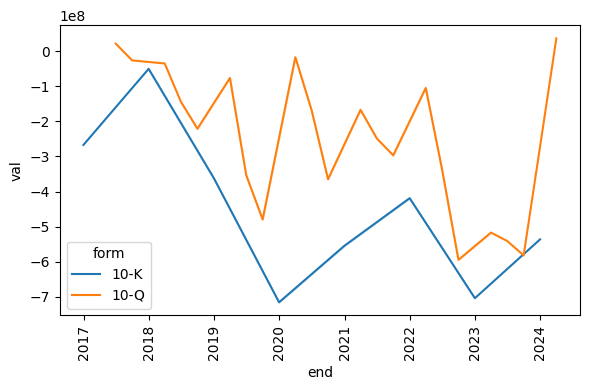

In [19]:
plt.figure(figsize=(6,4))
sns.lineplot(data=clean_df[(clean_df["ticker"] == "SRPT") & (clean_df["type"] == "ProfitLoss")], y="val", x="end", hue="form")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#### Observation:
- Apart from the last graph, the accounts value evolution seems to be the same for both forms.
- For sake of simplicity, let's not split the data by type of form (10-k or 10-Q), and thus, drop this column

#### Decision:
- **Keep only ticker, end, and type columns**
- Pivot the account types to columns and fill the NaN values with 0s. **We assume filling the NaNs with 0s won't have impact in the model. IF WE DON'T FILL_NA by 0s, we have an average of 98% NaN values in the dataset.**
- Optimize memory usage by converting the numerical columns to int32
- Add more stock-related features as columns to the df
- Save the dataframe to csv file and move it to a s3 bucket
- In the meantime, let's do some experimentations below to see if we can apply a model

Alternatives to dealing with NaN values:
1. drop the columns with x % of NaNs
2. NaNs as the mean of the columb
3. cutoffs
4. regression to calculate NaNs
5. shorten the period
6. shorten the number of columns

In [20]:
end_df = pd.pivot_table(data= clean_df, values="val",columns="type", index=["ticker","end"], aggfunc='mean', fill_value=0).reset_index().copy()

In [21]:
# Optimizing memory
cols = end_df.columns[2:]
end_df[cols] = end_df[cols].astype(np.int32)

In [22]:
end_df.shape

(31248, 4803)

In [23]:
end_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 31248 entries, 0 to 31247
Columns: 4803 entries, ticker to WriteOffOfDeferredDebtIssuanceCost
dtypes: datetime64[ns](1), int32(4801), object(1)
memory usage: 572.8+ MB


##### FLAG !
We need to move this dataframe to a database. It's using 573 MB already without close_price, volume, and number_shares columns
Without pivot, we were only using memory usage: 244.3+ MB

##### Number of NaNs per columns (only applicable if the fill_na is np.NaN)

In [24]:
len(end_df.columns)

4803

In [25]:
nans_per_type = (end_df.isna().sum()/len(end_df)).reset_index().rename({0:"Percentage of NaNs"}, axis=1)
nans_per_type["Percentage of NaNs"].sum()/len(nans_per_type)

0.0

### Addding stock info to the df
- close price per day
- volume of shares traded per day
- number of outstanding shares
- earnings per share - https://www.investopedia.com/terms/e/eps.asp#:~:text=For%20instance%2C%20a%20company%20can,earnings%20can%20also%20change%20EPS.

In [26]:
# This method you Open, High, Close, Low, Close, Adj Close, Volume - Year - month - day
def get_stock_details(ticker,start_date,end_date):
    df = yf.download(ticker, start=start_date, end=end_date).reset_index()[["Date","Close","Volume"]]
    df["Close"] = df["Close"].astype("float32")
    df["Volume"] = df["Volume"].astype("int32")
    df["ticker"] = ticker
    return df.iloc[:,[3,0,1,2]]

def get_number_of_shares(ticker,start_date):
    stock = yf.Ticker(ticker)
    df = pd.DataFrame(stock.get_shares_full(start=start_date)).reset_index().rename({"index":"Date", 0:"Shares"}, axis=1)
    df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')
    df = df.set_index("Date").tz_convert(None).reset_index()
    df["ticker"] = ticker
    return df.iloc[:,[2,0,1]]

# When joined with the end_df, we need to fill_na with the value from the previous existent value in that column -> fillna(method='ffill')
def get_earnigns_per_share(ticker):
    df = yf.Ticker("AAPL").get_earnings_dates(limit=150)[["Reported EPS"]].reset_index().rename({"Earnings Date":"Date"}, axis=1)
    df["Date"] = pd.to_datetime(df["Date"], format='%Y-%m-%d')
    df = df.set_index("Date").tz_convert(None).reset_index()
    df["ticker"] = ticker
    return df.iloc[:,[2,0,1]]

#### Testing the merge with the AADI stock

In [27]:
ticker = end_df["ticker"].unique()[0]
start_date = end_df[end_df["ticker"]==ticker].end.min()
end_date = end_df[end_df["ticker"]==ticker].end.max()

In [39]:
stock_details = get_stock_details(ticker,start_date,end_date) # close price, volume
number_of_shares = get_number_of_shares(ticker,start_date) # number of outstanding shares
earnings_per_share = get_earnigns_per_share(ticker) # earnings per share

[*********************100%%**********************]  1 of 1 completed


In [29]:
print(stock_details.info())
print()
print(number_of_shares.info())
print()
print(earnings_per_share.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1538 entries, 0 to 1537
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ticker  1538 non-null   object        
 1   Date    1538 non-null   datetime64[ns]
 2   Close   1538 non-null   float32       
 3   Volume  1538 non-null   int32         
dtypes: datetime64[ns](1), float32(1), int32(1), object(1)
memory usage: 36.2+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 218 entries, 0 to 217
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   ticker  218 non-null    object        
 1   Date    218 non-null    datetime64[ns]
 2   Shares  218 non-null    int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 5.2+ KB
None

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128 entries, 0 to 127
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtyp

In [30]:
stock_details.Date.min()

Timestamp('2018-02-16 00:00:00')

In [31]:
start_date

Timestamp('2007-11-14 00:00:00')

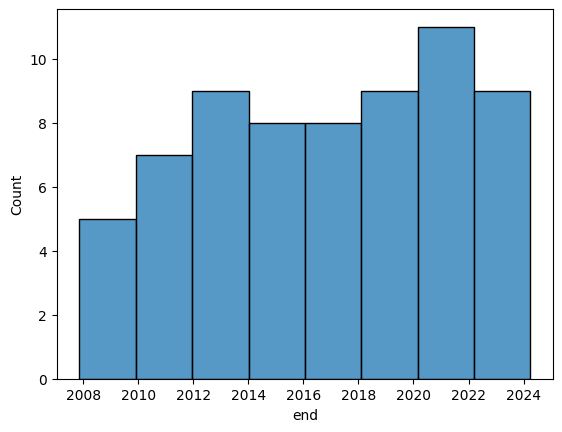

In [32]:
# let's use the AADI company as a test for our merger and EDA
sns.histplot(data=end_df[end_df["ticker"]==ticker], x=end_df[end_df["ticker"]==ticker].end)
plt.show()

**Discovery:**
- The earliest date available for the stock price and column is 2018-02-16.
- However, we have filings for AADI in the SEC that go back to 2007-11-14. This is making the merge with a lof of NaN values.
**So what is hapening here?**

If you have SEC data from 2007 but the company started trading publicly in 2018, here are some potential explanations:

1. Predecessor Companies: Aadi Bioscience might have been involved in corporate transactions such as mergers, acquisitions, or reorganizations. The filings from 2007 could be related to a predecessor company or a related entity before the current entity (Aadi Bioscience) emerged or rebranded.

2. Private Company Filings: Some private companies are required to file reports with the SEC even before they go public. For instance, they might issue certain types of securities (like debt) that require regular reporting.

3. Registration and Preparatory Filings: Companies preparing for an IPO often have a series of filings well before the actual public listing date. These include registration statements, amendments, and responses to SEC comments.

4. Regulatory Requirements: Companies may have specific regulatory or legal reasons for filing reports with the SEC even if they are not publicly traded. This could be due to specific transactions, securities issued, or compliance with other regulatory frameworks.

**CONSTRAINT FLAG** We can have financial statement data even if the companies are not publicly traded on the market stock exchange.

**Solution**: ??? Which leaves the question, should we keep the records before that date? if we keep them, do we fill the nans with something? should we create a binary column saying traded/not traded?

### Adding the stock info columns with a left join merge

In [40]:
# 1st Attempt
temp_df = pd.merge(end_df[end_df["ticker"]==ticker], stock_details, how="left", left_on="end",right_on="Date", suffixes=('', '_y')).drop(["ticker_y","Date"], axis=1)
temp_df = pd.merge(temp_df,number_of_shares, how="left", left_on="end",right_on="Date", suffixes=('', '_y')).drop(["ticker_y","Date"], axis=1)
temp_df = pd.merge(temp_df,earnings_per_share, how="left", left_on="end",right_on="Date", suffixes=('', '_y')).drop(["ticker_y","Date"], axis=1)
temp_df[30:]

,ticker,end,AcceleratedShareRepurchaseProgramAdjustment,AcceleratedShareRepurchasesAdjustmentToRecordedAmount,AcceleratedShareRepurchasesSettlementPaymentOrReceipt,AccountsAndFinancingReceivableAllowanceForCreditLoss,AccountsAndNotesReceivableNet,AccountsAndOtherReceivablesNetCurrent,AccountsNotesAndLoansReceivableNetCurrent,AccountsPayable,...,WarrantDownRoundFeatureIncreaseDecreaseInEquityAmount1,WarrantsAndRightsOutstanding,WarrantsNotSettleableInCashFairValueDisclosure,WeightedAverageCostInventoryAmount,WorkersCompensationLiabilityCurrent,WriteOffOfDeferredDebtIssuanceCost,Close,Volume,Shares,Reported EPS
30,AADI,2016-06-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
31,AADI,2016-09-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
32,AADI,2016-12-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
33,AADI,2017-03-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
34,AADI,2017-06-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
35,AADI,2017-09-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
36,AADI,2017-12-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
37,AADI,2018-03-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN
38,AADI,2018-06-28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,62.849998,16320.0,NaN,NaN
39,AADI,2018-06-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,NaN


**Discovery**:
- The dates of the financial statements are sometimes weekends or holidays where the stock exchanges are not open. Therefore, we need to keep the close price and volume of the last available date.
- Also, regarding the Number of Shares and EPS, we have data on limited dates. Why? Because the rows only contain the dates when there was a change to the metric. If # of shares of EPS remains constant on a certain date, that date won't appear on the df.

**Solution**
- To solve these 2 issues, we will get the list of dates of each company, and force insert on the 3 stock info dfs and forward filled them with the value of the last date available.

In [41]:
# 1st step: Inserting the dates that the stock_details doesn't contain and fill the values with the value of the last date available

for date in end_df[end_df["ticker"]==ticker].end:
    if date not in stock_details.Date.tolist() and date >= stock_details.Date.min():
        new_row = pd.DataFrame([[ticker, date, np.nan, np.nan]], columns=stock_details.columns)
        stock_details = pd.concat([stock_details, new_row], ignore_index=True)

stock_details = stock_details.sort_values("Date").ffill()
stock_details

/var/folders/rq/mp23sqb51172w_hxsktx212r0000gn/T/ipykernel_12171/2825783464.py:6: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  stock_details = pd.concat([stock_details, new_row], ignore_index=True)


,ticker,Date,Close,Volume
0,AADI,2018-02-16,67.500000,1527.0
1,AADI,2018-02-20,66.000000,353.0
2,AADI,2018-02-21,71.250000,733.0
3,AADI,2018-02-22,68.745003,213.0
4,AADI,2018-02-23,67.500000,360.0
...,...,...,...,...
1534,AADI,2024-03-25,2.170000,253200.0
1535,AADI,2024-03-26,2.200000,230600.0
1536,AADI,2024-03-27,2.370000,280700.0
1537,AADI,2024-03-28,2.340000,349200.0


In [42]:
# 2ndt step: Inserting the dates that the number_of_shares df doesn't contain and fill the values with the value of the last date available

for date in end_df[end_df["ticker"]==ticker].end:
    if date not in number_of_shares.Date.tolist() and date >= number_of_shares.Date.min():
        new_row = pd.DataFrame([[ticker, date, np.nan]], columns=number_of_shares.columns)
        number_of_shares = pd.concat([number_of_shares, new_row], ignore_index=True)

number_of_shares = number_of_shares.sort_values("Date").ffill()
number_of_shares

,ticker,Date,Shares
0,AADI,2021-08-31 04:00:00,20800000.0
1,AADI,2021-09-01 04:00:00,20800000.0
2,AADI,2021-09-29 04:00:00,20869300.0
218,AADI,2021-09-30 00:00:00,20869300.0
3,AADI,2021-10-06 04:00:00,21887500.0
...,...,...,...
213,AADI,2024-05-12 04:00:00,24554200.0
214,AADI,2024-05-14 04:00:00,24554200.0
215,AADI,2024-05-17 04:00:00,24554200.0
216,AADI,2024-05-18 04:00:00,24618500.0


In [43]:
# 3rd step: Inserting the dates that the earnings_per_share df doesn't contain and fill the values with the value of the last date available

for date in end_df[end_df["ticker"]==ticker].end:
    if date not in earnings_per_share.Date.tolist() and date >= earnings_per_share.Date.min():
        new_row = pd.DataFrame([[ticker, date, np.nan]], columns=earnings_per_share.columns)
        earnings_per_share = pd.concat([earnings_per_share, new_row], ignore_index=True)

earnings_per_share = earnings_per_share.sort_values("Date").ffill()
earnings_per_share

,ticker,Date,Reported EPS
127,AADI,1993-01-16 05:00:00,0.01
126,AADI,1993-04-20 04:00:00,0.01
125,AADI,1993-07-16 04:00:00,0.01
124,AADI,1993-10-15 04:00:00,0.01
123,AADI,1994-01-21 05:00:00,0.01
...,...,...,...
4,AADI,2024-08-01 10:00:00,1.53
3,AADI,2024-10-31 10:00:00,1.53
2,AADI,2025-01-30 21:00:00,1.53
1,AADI,2025-02-27 17:00:00,1.53


In [45]:
# 4th step: Merging the columns
temp_df = pd.merge(end_df[end_df["ticker"]==ticker], stock_details, how="left", left_on="end",right_on="Date", suffixes=('', '_y')).drop(["ticker_y","Date"], axis=1)
temp_df = pd.merge(temp_df,number_of_shares, how="left", left_on="end",right_on="Date", suffixes=('', '_y')).drop(["ticker_y","Date"], axis=1)
temp_df = pd.merge(temp_df,earnings_per_share, how="left", left_on="end",right_on="Date", suffixes=('', '_y')).drop(["ticker_y","Date"], axis=1)
temp_df[30:]

,ticker,end,AcceleratedShareRepurchaseProgramAdjustment,AcceleratedShareRepurchasesAdjustmentToRecordedAmount,AcceleratedShareRepurchasesSettlementPaymentOrReceipt,AccountsAndFinancingReceivableAllowanceForCreditLoss,AccountsAndNotesReceivableNet,AccountsAndOtherReceivablesNetCurrent,AccountsNotesAndLoansReceivableNetCurrent,AccountsPayable,...,WarrantDownRoundFeatureIncreaseDecreaseInEquityAmount1,WarrantsAndRightsOutstanding,WarrantsNotSettleableInCashFairValueDisclosure,WeightedAverageCostInventoryAmount,WorkersCompensationLiabilityCurrent,WriteOffOfDeferredDebtIssuanceCost,Close,Volume,Shares,Reported EPS
30,AADI,2016-06-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.48
31,AADI,2016-09-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.36
32,AADI,2016-12-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.42
33,AADI,2017-03-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.84
34,AADI,2017-06-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.53
35,AADI,2017-09-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.42
36,AADI,2017-12-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.52
37,AADI,2018-03-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,71.250000,600.0,NaN,0.97
38,AADI,2018-06-28,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,62.849998,16320.0,NaN,0.68
39,AADI,2018-06-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,62.250000,14687.0,NaN,0.68


In [47]:
temp_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 66 entries, 0 to 65
Columns: 4807 entries, ticker to Reported EPS
dtypes: datetime64[ns](1), float32(1), float64(3), int32(4801), object(1)
memory usage: 1.2+ MB


In [67]:
model_df = pd.DataFrame(columns=end_df.columns)

tickers = end_df["ticker"].unique()


# for ticker in tickers: ONLY RUN THIS ONE WHEN YOU WANT ALL THE ROWS
for ticker in tickers[:10]:
    ticker = ticker
    start_date = end_df[end_df["ticker"]==ticker].end.min()
    end_date = end_df[end_df["ticker"]==ticker].end.max()
    
    stock_details = get_stock_details(ticker,start_date,end_date) # close price, volume
    number_of_shares = get_number_of_shares(ticker,start_date) # number of outstanding shares
    earnings_per_share = get_earnigns_per_share(ticker) # earnings per share

    # stock_details
    for date in end_df[end_df["ticker"]==ticker].end:
        if date not in stock_details.Date.tolist() and date >= stock_details.Date.min():
            new_row = pd.DataFrame([[ticker, date, np.nan, np.nan]], columns=stock_details.columns)
            stock_details = pd.concat([stock_details, new_row], ignore_index=True)  
    stock_details = stock_details.sort_values("Date").ffill()

    # number_of_shares
    for date in end_df[end_df["ticker"]==ticker].end:
        if date not in number_of_shares.Date.tolist() and date >= number_of_shares.Date.min():
            new_row = pd.DataFrame([[ticker, date, np.nan]], columns=number_of_shares.columns)
            number_of_shares = pd.concat([number_of_shares, new_row], ignore_index=True)
    number_of_shares = number_of_shares.sort_values("Date").ffill()

    # earnings_per_share
    for date in end_df[end_df["ticker"]==ticker].end:
        if date not in earnings_per_share.Date.tolist() and date >= earnings_per_share.Date.min():
            new_row = pd.DataFrame([[ticker, date, np.nan]], columns=earnings_per_share.columns)
            earnings_per_share = pd.concat([earnings_per_share, new_row], ignore_index=True)
    earnings_per_share = earnings_per_share.sort_values("Date").ffill()


    # Merges
    temp_df = pd.merge(end_df[end_df["ticker"]==ticker], stock_details, how="left", left_on="end",right_on="Date", suffixes=('', '_y')).drop(["ticker_y","Date"], axis=1)
    temp_df = pd.merge(temp_df,number_of_shares, how="left", left_on="end",right_on="Date", suffixes=('', '_y')).drop(["ticker_y","Date"], axis=1)
    temp_df = pd.merge(temp_df,earnings_per_share, how="left", left_on="end",right_on="Date", suffixes=('', '_y')).drop(["ticker_y","Date"], axis=1)

    # Final concat
    model_df = pd.concat([model_df, temp_df], ignore_index=True)

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


In [68]:
model_df.ticker.nunique()

10

In [69]:
model_df

,ticker,end,AcceleratedShareRepurchaseProgramAdjustment,AcceleratedShareRepurchasesAdjustmentToRecordedAmount,AcceleratedShareRepurchasesSettlementPaymentOrReceipt,AccountsAndFinancingReceivableAllowanceForCreditLoss,AccountsAndNotesReceivableNet,AccountsAndOtherReceivablesNetCurrent,AccountsNotesAndLoansReceivableNetCurrent,AccountsPayable,...,WarrantDownRoundFeatureIncreaseDecreaseInEquityAmount1,WarrantsAndRightsOutstanding,WarrantsNotSettleableInCashFairValueDisclosure,WeightedAverageCostInventoryAmount,WorkersCompensationLiabilityCurrent,WriteOffOfDeferredDebtIssuanceCost,Close,Volume,Shares,Reported EPS
0,AADI,2007-11-14,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.04
1,AADI,2007-11-15,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.04
2,AADI,2007-11-16,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.04
3,AADI,2007-12-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.04
4,AADI,2008-12-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,NaN,NaN,NaN,0.05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
671,ACAD,2022-12-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,15.920000,814600.0,161931008.0,1.29
672,ACAD,2023-03-31,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,18.820000,1539200.0,167072000.0,1.88
673,ACAD,2023-06-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,23.950001,1036100.0,162624992.0,1.52
674,ACAD,2023-09-30,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,20.840000,2991100.0,163728992.0,1.26


## Modelling

#### Other sources of data

#### Financial statements from Yahoo Finance

In [34]:
aapl = yf.Ticker("AAPL")

In [35]:
# Last 4 years
aapl.balance_sheet.shape

(62, 4)

In [36]:
# Last 5 quarters
aapl.quarterly_balance_sheet.shape

(63, 5)

In [37]:
# Last 4 years
aapl.cashflow.shape

(53, 4)

In [38]:
# Last 5 quarters
aapl.quarterly_cashflow.shape

(47, 5)

In [39]:
# Last 4 years
aapl.income_stmt.shape

(39, 4)

In [40]:
# Last 5 quarters
aapl.quarterly_income_stmt.shape

(39, 5)

#### Insider transactions

In [41]:
yf.Ticker("AAPL").institutional_holders

,Date Reported,Holder,pctHeld,Shares,Value
0,2023-06-30,Vanguard Group Inc,0.0834,1303688506,252876459508
1,2023-06-30,Blackrock Inc.,0.0665,1039640859,201659137420
2,2023-06-30,"Berkshire Hathaway, Inc",0.0586,915560382,177591247296
3,2023-06-30,State Street Corporation,0.0370,578897858,112288817516
4,2023-06-30,"FMR, LLC",0.0196,307066638,59561715772
5,2023-06-30,"Geode Capital Management, LLC",0.0186,291538165,56549657865
6,2023-06-30,Price (T.Rowe) Associates Inc,0.0145,226650943,43963483413
7,2023-06-30,Morgan Stanley,0.0131,204714950,39708558851
8,2022-12-31,Norges Bank Investment Management,0.0107,167374278,21746939940
9,2023-06-30,Northern Trust Corporation,0.0105,164536073,31915062079


In [42]:
yf.Ticker("AAPL").mutualfund_holders

,Date Reported,Holder,pctHeld,Shares,Value
0,2023-06-30,Vanguard Total Stock Market Index Fund,0.0298,465990265,90388131702
1,2023-06-30,Vanguard 500 Index Fund,0.0225,352024182,68282130582
2,2023-08-31,Fidelity 500 Index Fund,0.0108,169378703,31821176932
3,2023-09-30,SPDR S&P 500 ETF Trust,0.0106,165192563,28282618711
4,2023-09-30,iShares Core S&P 500 ETF,0.0089,138984763,23795581273
5,2023-06-30,Vanguard Growth Index Fund,0.0081,127130805,24659562245
6,2023-08-31,"Invesco ETF Tr-Invesco QQQ Tr, Series 1 ETF",0.0080,124293053,23350935867
7,2023-06-30,Vanguard Institutional Index Fund-Institutiona...,0.0065,100926716,19576755102
8,2023-08-31,Vanguard Information Technology Index Fund,0.0049,76972129,14460753875
9,2023-09-30,Select Sector SPDR Fund-Technology,0.0041,64568089,11054702517


In [43]:
yf.Ticker("AAPL").insider_transactions

,Shares,Value,URL,Text,Insider,Position,Transaction,Start Date,Ownership
0,1850,0.0,,Stock Gift at price 0.00 per share.,ADAMS KATHERINE L,General Counsel,,2024-05-10,D
1,8119,NaN,,,KONDO CHRISTOPHER,Officer,,2024-04-15,D
2,59162,10188880.0,,Sale at price 172.22 per share.,WILLIAMS JEFFREY E,Chief Operating Officer,,2024-04-11,I
3,53194,9261933.0,,Sale at price 173.19 - 175.02 per share.,MAESTRI LUCA,Chief Financial Officer,,2024-04-11,D
4,196410,33258614.0,,Sale at price 168.62 - 170.03 per share.,COOK TIMOTHY D,Chief Executive Officer,,2024-04-02,D
...,...,...,...,...,...,...,...,...,...
145,31200,3737869.0,,Sale at price 119.58 - 120.14 per share.,O'BRIEN DEIRDRE,Officer,,2020-10-16,D
146,23652,NaN,,,KONDO CHRISTOPHER,Officer,,2020-10-15,D
147,66532,NaN,,,O'BRIEN DEIRDRE,Officer,,2020-10-15,D
148,243431,28454650.0,,Sale at price 116.89 per share.,MAESTRI LUCA,Chief Financial Officer,,2020-10-09,D


In [44]:
yf.Ticker("AAPL").insider_roster_holders

,Name,Position,URL,Most Recent Transaction,Latest Transaction Date,Shares Owned Directly,Position Direct Date,Shares Owned Indirectly,Position Indirect Date
0,ADAMS KATHERINE L,General Counsel,,Stock Gift,2024-05-10,291543.0,2024-05-10,NaN,NaN
1,COOK TIMOTHY D,Chief Executive Officer,,Sale,2024-04-02,3280180.0,2024-04-02,NaN,NaN
2,JUNG ANDREA,Director,,Conversion of Exercise of derivative security,2024-02-01,74489.0,2024-02-01,NaN,NaN
3,KONDO CHRISTOPHER,Officer,,Conversion of Exercise of derivative security,2024-04-15,34277.0,2024-04-15,NaN,NaN
4,LEVINSON ARTHUR D,Director,,Sale,2024-02-29,4490580.0,2024-02-29,NaN,NaN
5,MAESTRI LUCA,Chief Financial Officer,,Sale,2024-04-11,107788.0,2024-04-11,NaN,NaN
6,O'BRIEN DEIRDRE,Officer,,Sale,2024-04-02,136572.0,2024-04-02,NaN,NaN
7,SUGAR RONALD D,Director,,Conversion of Exercise of derivative security,2024-02-01,107795.0,2024-02-01,NaN,NaN
8,WAGNER SUSAN L,Director,,Conversion of Exercise of derivative security,2024-02-01,67375.0,2024-02-01,NaN,NaN
9,WILLIAMS JEFFREY E,Chief Operating Officer,,Sale,2024-04-11,NaN,NaT,489944.0,1.712794e+09


#### LLM on news

In [45]:
def get_recent_news(ticker):

    # Gives you a json with the 8 most recent news about that company
    news_list = yf.Ticker(ticker).news
    
    data = []
    for news in news_list:
        ticker = ticker
        title = news['title'] if 'title' in news else None
        link = news['link'] if 'link' in news else None
        date_unix = news['providerPublishTime'] if 'providerPublishTime' in news else None
        date = datetime.utcfromtimestamp(date_unix).strftime('%Y-%m-%d %HH:%MM') if date_unix else None
        companies_involved = news['relatedTickers'] if 'relatedTickers' in news else None
        
        data.append({
            'ticker': ticker,
            'title': title,
            'link': link,
            'date': date,
            'companies_involved': companies_involved
        })
    
    df = pd.DataFrame(data)
    return df

# Example usage
recent_news = get_recent_news("AAPL")
recent_news

,ticker,title,link,date,companies_involved
0,AAPL,From Artificial Intelligence (AI) to iPhones t...,https://finance.yahoo.com/m/2ba6b482-d7dc-38cd...,2024-05-19 18H:00M,[AAPL]
1,AAPL,3 Reasons to Buy Apple Stock Like There's No T...,https://finance.yahoo.com/m/fc483829-e48b-35a0...,2024-05-19 14H:15M,[AAPL]
2,AAPL,Facebook Parent’s Plan to Win AI Race: Give It...,https://finance.yahoo.com/m/9f95482a-959c-3e5e...,2024-05-19 13H:00M,"[GOOG, META, AAPL]"
3,AAPL,"World’s Largest Hedge Fund Bet Big on Apple, N...",https://finance.yahoo.com/m/ddb986d5-5d04-3c41...,2024-05-19 09H:00M,"[AAPL, MSFT, NVDA]"
4,AAPL,Could Warren Buffett Like This Stock More Than...,https://finance.yahoo.com/m/2563d8e8-02ad-3986...,2024-05-18 09H:48M,"[AAPL, OXY-WS]"
5,AAPL,Forget Amazon: This Stock Has Made Far More Mi...,https://finance.yahoo.com/m/54fd02f0-ad84-3d3d...,2024-05-18 08H:45M,"[AAPL, AMZN]"
6,AAPL,"1 Unstoppable Stock That Could Join Microsoft,...",https://finance.yahoo.com/m/f7a6fde4-f8a5-3895...,2024-05-18 08H:07M,"[NVDA, TSM, AAPL, GOOG, MSFT, AMZN]"
7,AAPL,The 'Magnificent 7' term needs to be retired a...,https://finance.yahoo.com/news/magnificent-7-t...,2024-05-18 05H:39M,"[TSLA, AAPL, AMZN, GOOG]"


In [46]:
recent_news["link"]

0    https://finance.yahoo.com/m/2ba6b482-d7dc-38cd...
1    https://finance.yahoo.com/m/fc483829-e48b-35a0...
2    https://finance.yahoo.com/m/9f95482a-959c-3e5e...
3    https://finance.yahoo.com/m/ddb986d5-5d04-3c41...
4    https://finance.yahoo.com/m/2563d8e8-02ad-3986...
5    https://finance.yahoo.com/m/54fd02f0-ad84-3d3d...
6    https://finance.yahoo.com/m/f7a6fde4-f8a5-3895...
7    https://finance.yahoo.com/news/magnificent-7-t...
Name: link, dtype: object